## Import Library

In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import sys
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from model.unet import Model      # UNet
# from model.efficientnet_unet import Model  # EfficientNet (Encoder) + UNet (Decoder)

from dataset.dataset import Dataset
from utils.visualize import visualize_predictions

## Set Global Variable

In [2]:
# Freeze seed
torch.manual_seed(0)

# Define paths
CHECKPOINT_PATH = 'checkpoint/2023_12_10_215423_UNet/UNet.pth'
TRAIN_INDEX_PATH = 'data/train_toy_idx.txt'
TEST_INDEX_PATH = 'data/test_toy_idx.txt'

# Define modes
MODE = 'test'                              # train/test
RECORD = False                              # Record predictions in wandb
SAVE_MODEL_NAME = 'UNet'       # Name of model to save

# Define hyperparameters
EPOCHS = 5
BATCH_SIZE = 1                              # While MODE = 'test', remember to set BATCH_SIZE = 1
LEARNING_RATE = 1e-4

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Setup WanDB for tracking

In [3]:
import wandb
from datetime import datetime


def get_current_timestamp():
    now = datetime.now()
    timestamp = now.strftime("%Y_%m_%d_%H%M%S")
    return timestamp

timestamp = get_current_timestamp()
log_dir = f'checkpoint/{timestamp}_{SAVE_MODEL_NAME}'

if RECORD and MODE == 'train':
    wandb.init(
        # set the wandb project where this run will be logged
        project="Face_Segmentation",
        name=f'{timestamp}_{SAVE_MODEL_NAME}',
        
        # track hyperparameters and run metadata
        config={
        "learning_rate": 1e-4,
        "architecture": "CNN",
        "dataset": "CelebAMaskHQ",
        "epochs": 30,
        }
    )

## Set Current Working Directory to current location

In [4]:
# Change current working directory to file location
current_folder = globals()['_dh'][0]
os.chdir(current_folder)

# Change to the below code if in python file
# os.chdir(os.path.dirname(__file__))

## Setup model

In [5]:
# Create U-Net model
model = Model(3, 19)
model = model.to(device)

# Print total number of parameters
print(f'Total number of parameters: {sum(p.numel() for p in model.parameters())}')

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Load dataset
train_dataset = Dataset(id_file=TRAIN_INDEX_PATH, transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = Dataset(id_file=TEST_INDEX_PATH, transform=ToTensor())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Total number of parameters: 31038803


## Training function

In [6]:
def train(model, train_loader, test_loader, criterion, optimizer):
    lowest_test_loss = 1e10
    if CHECKPOINT_PATH != '':
        model.load_state_dict(torch.load(CHECKPOINT_PATH))
        print('Loaded model from checkpoint.')
    model.train()
    all_train_loss = []
    all_test_loss = []
    for epoch in tqdm(range(EPOCHS), leave=True):
        
        for images, masks in tqdm(train_loader, leave=False):
            images = images.to(device)
            masks = masks.to(device).squeeze(1)

            # Forward pass
            outputs = model(images)
            train_loss = criterion(outputs, masks)

            # Backward and optimize
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            for images, masks in tqdm(test_loader, leave=False):
                images = images.to(device)
                masks = masks.to(device).squeeze(1)

                # Forward pass
                outputs = model(images)
                test_loss = criterion(outputs, masks)

            # Save model with lowest test loss
            if test_loss.item() < lowest_test_loss:
                lowest_test_loss = test_loss.item()
                if not os.path.exists(log_dir) and MODE == 'train':
                    os.makedirs(log_dir)
                if os.path.exists(f'{log_dir}/{SAVE_MODEL_NAME}.pth'):
                    os.rename(f'{log_dir}/{SAVE_MODEL_NAME}.pth', f'{log_dir}/{SAVE_MODEL_NAME}_{get_current_timestamp()}.pth')
                torch.save(model.state_dict(), f'{log_dir}/{SAVE_MODEL_NAME}.pth')

            tqdm.write(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
            all_train_loss.append(train_loss.item())
            all_test_loss.append(test_loss.item())

        if RECORD:
            wandb.log({"train_loss": train_loss.item(), "test_loss": test_loss.item()})

    # Plot loss
    plt.plot(all_train_loss, label='Training loss')
    plt.plot(all_test_loss, label='Testing loss')
    plt.legend()
    plt.savefig(f'{log_dir}/loss.png')
    plt.show()

## Testing function

In [7]:
def test(model, test_loader):
    model.load_state_dict(torch.load(CHECKPOINT_PATH))
    model.eval()
    total = 0
    correct = 0
    for images, masks in tqdm(test_loader):
        images = images.to(device)
        masks = masks.to(device).squeeze(1)

        outputs = model(images)
        loss = criterion(outputs, masks)
        _, predicted = torch.max(outputs.data, 1)
        
        ## Visualize predictions with first image
        visualize_predictions(images, predicted, masks)
        # break

    print(f'Test Loss: {loss.item():.4f}')

## Setup Prediction function

In [8]:
labels_celeb = ['background', 'skin', 'nose',
                'eye_g', 'l_eye', 'r_eye', 'l_brow',
                'r_brow', 'l_ear', 'r_ear', 'mouth',
                'u_lip', 'l_lip', 'hair', 'hat',
                'ear_r', 'neck_l', 'neck', 'cloth']


def read_mask(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if type(img) is type(None):
        return np.zeros((256, 256, 1), dtype=np.uint8)
    return img


def mask2binary(path):
    mask = read_mask(path)
    mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
    mask = np.where(mask > 0, 1, 0)
    return mask


def rle_encode(img):
    pixels = img.flatten()
    if np.sum(pixels) == 0:
        return '0'
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    # to string sep='_'
    runs = '_'.join(str(x) for x in runs)
    return runs


def rle_decode(mask_rle, shape):
    s = mask_rle.split('_')
    s = [0 if x == '' else int(x) for x in s]
    if np.sum(s) == 0:
        return np.zeros(shape, dtype=np.uint8)
    starts, lengths = [np.asarray(x, dtype=int)
                       for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 255
    return img.reshape(shape)


def mask2csv(mask_paths, csv_path='mask.csv', image_id=1, header=False):
    """
        mask_paths: dict of label:mask_paths
        ['label1':path1,'label2':path2,...]
    """
    results = []
    for i, label in enumerate(labels_celeb):
        try:
            mask = mask2binary(mask_paths[label])
        except:
            mask = np.zeros((256, 256), dtype=np.uint8)
        mask = rle_encode(mask)
        results.append(mask)
    df = pd.DataFrame(results)
    df.insert(0, 'label', labels_celeb)
    df.insert(0, 'Usage', ["Public" for i in range(len(results))])
    df.insert(0, 'ID', [image_id*19+i for i in range(19)])
    if header:
        df.columns = ['ID', 'Usage', 'label', 'segmentation']
    # print()
    # print(df)
    df.to_csv(csv_path, mode='a', header=header, index=False)


def mask2csv2(masks, csv_path='mask.csv', image_id=1, header=False):
    """
        mask_paths: dict of label:mask
        ['label1':mask1,'label2':mask2,...]
    """
    results = []
    for i, label in enumerate(labels_celeb):
        try:
            mask = masks[label]
        except:
            mask = np.zeros((256, 256), dtype=np.uint8)
        mask = rle_encode(mask)
        results.append(mask)
    df = pd.DataFrame(results)
    df.insert(0, 'label', labels_celeb)
    df.insert(0, 'Usage', ["Public" for i in range(len(results))])
    df.insert(0, 'ID', [image_id*19+i for i in range(19)])

    if header:
        df.columns = ['ID', 'Usage', 'label', 'segmentation']
    # print()
    # print(df)
    df.to_csv(csv_path, mode='a', header=header, index=False)

def export():
    pass

## Main function

  0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.1483


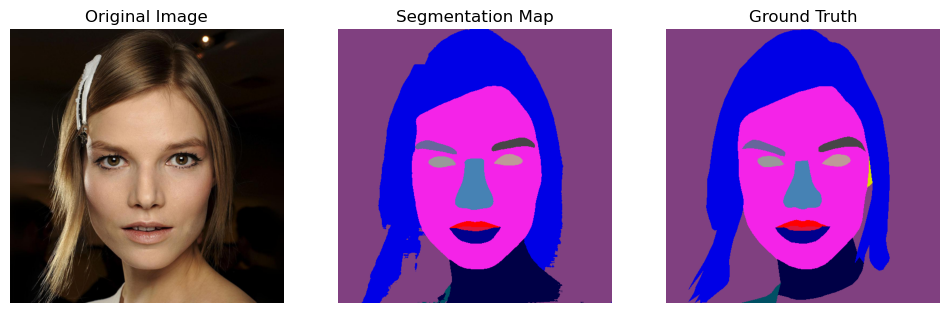

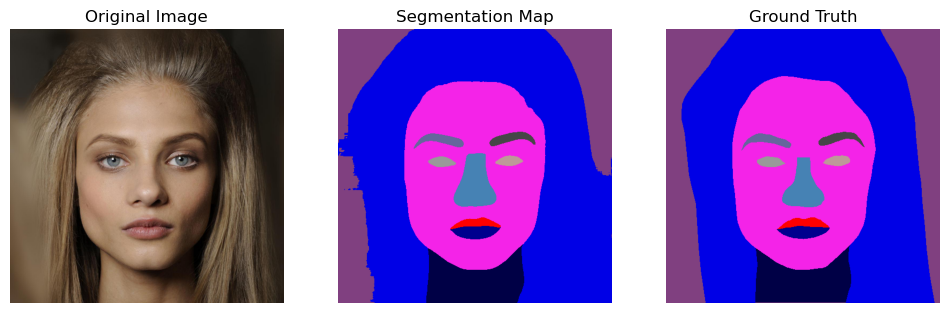

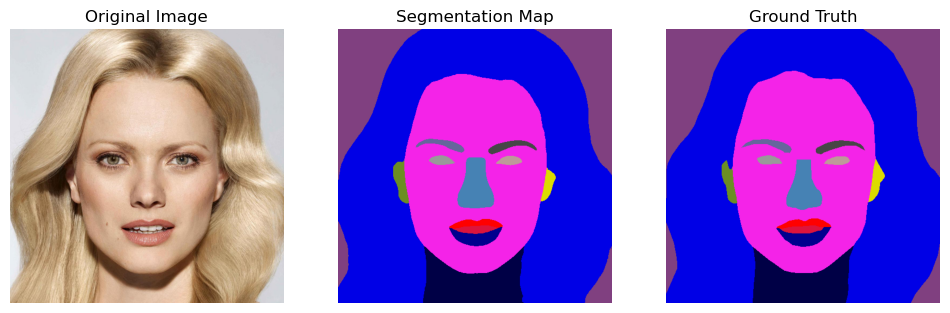

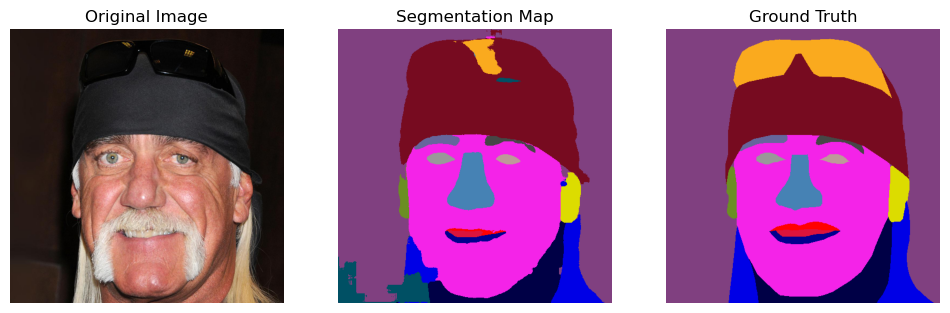

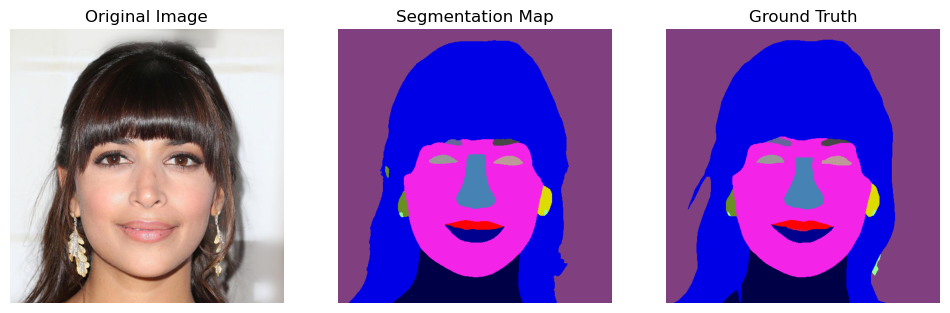

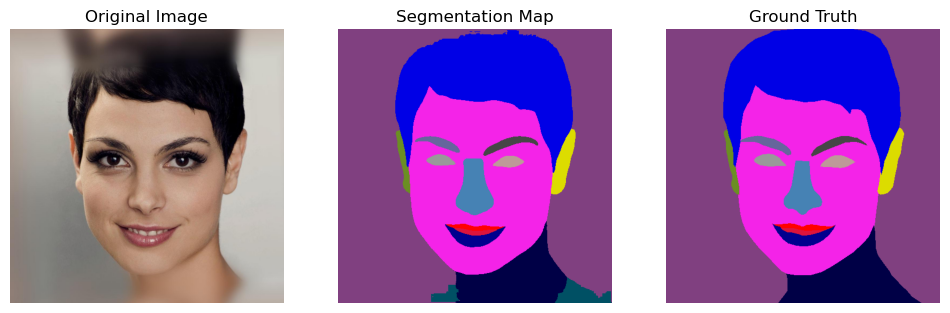

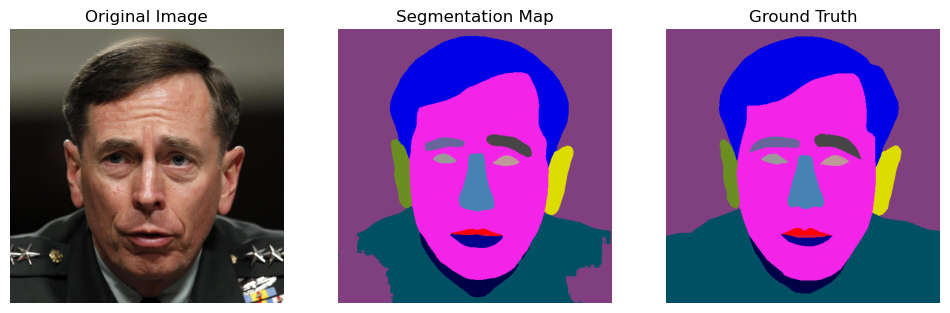

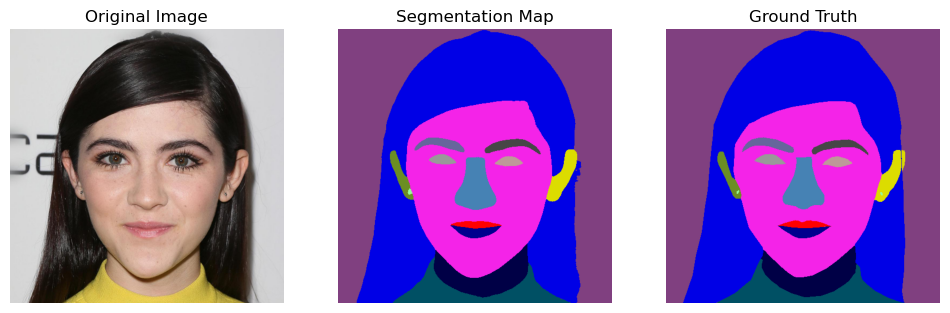

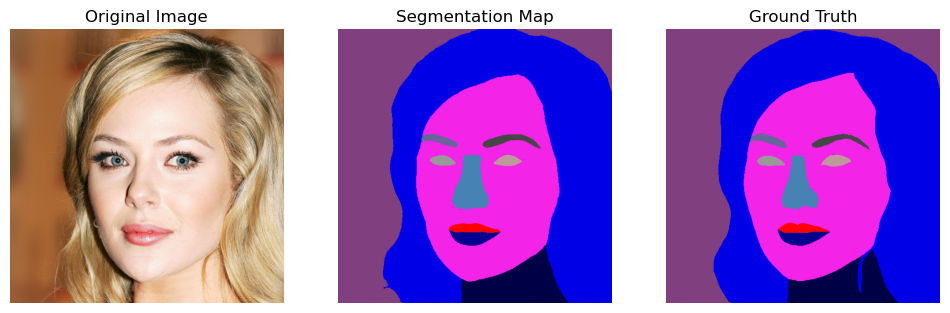

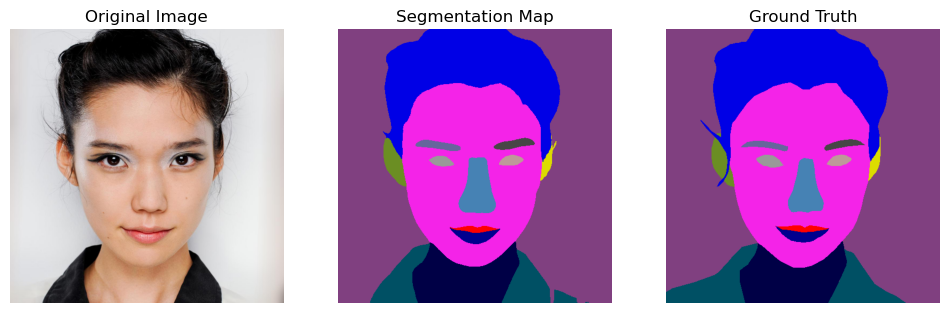

In [9]:

# Training loop
if MODE == 'train':
    train(model, train_loader, test_loader, criterion, optimizer)
elif MODE == 'test':
    test(model, test_loader)
elif MODE == 'csv':
    export()